In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from torchdyn.models import NeuralODE

from module import StructuredLNN
from nn import MLP, PSD

from gym_env import PendulumCustomEnv
from data import Gym_DataModule

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [3]:
env = PendulumCustomEnv(full_phase=True)
controls = np.array([[0.]])  # (num of control, dim)

# env, time step, traj, control
# 50 around one cycle
dataModule = Gym_DataModule(env, 100, 100, controls, time_horizon=5, batch_size=2048)
dataModule.setup()

M = PSD([2, 64, 64, 2], activation='softplus')  # Mass matrix, M(q)
V = MLP([2, 64, 64, 1], activation='softplus')  # Potential V(q)

LagFunc = StructuredLNN(massMatrixNet=M,
                        potentialNet=V,
                        dim=2)

LagODE = NeuralODE(LagFunc, sensitivity='adjoint', solver='dopri5').to(device)

def pendulum_lagrangian(q, p, l=1., m=1.):
    return p ** 2. / (2. * m * l) - m * 10. * l * (1-np.cos(q))

class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss
        self.n = self.model.defunc.m.n

    def forward(self, x_dx0, t_span):
        return self.model.trajectory(x_dx0, t_span)

    def training_step(self, batch, batch_idx):
        x, _, t, _ = batch
        t_span = t[0, :, 0]

        qs = x[:, :, :2]
        dqs = (qs[:, 1:, :self.n] - qs[:, 0:-1, :self.n]) / (t[:, 1:, :] - t[:, 0:-1, :])
        q_dq = torch.cat([qs[:, :-1, :], dqs], dim=2)

        cur_x_hat = self.model.trajectory(q_dq[:, 0, :], t_span[:-1])

        # Difference depends only on position
        loss = self.loss_func(q_dq, cur_x_hat.transpose(0, 1))

        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _, t, _ = batch
        t_span = t[0, :, 0]

        qs = x[:, :, :2]
        dqs = (qs[:, 1:, :self.n] - qs[:, 0:-1, :self.n]) / (t[:, 1:, :] - t[:, 0:-1, :])
        q_dq = torch.cat([qs[:, :-1, :], dqs], dim=2)

        cur_x_hat = self.model.trajectory(q_dq[:, 0, :], t_span[:-1])

        # Difference depends only on position
        loss = self.loss_func(q_dq, cur_x_hat.transpose(0, 1))

        self.log('val_loss', loss)
        self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
        return loss

    def test_step(self, batch, batch_idx):
        x, _, t, _ = batch
        t_span = t[0, :, 0]

        qs = x[:, :, :2]
        dqs = (qs[:, 1:, :self.n] - qs[:, 0:-1, :self.n]) / (t[:, 1:, :] - t[:, 0:-1, :])
        q_dq = torch.cat([qs[:, :-1, :], dqs], dim=2)

        cur_x_hat = self.model.trajectory(q_dq[:, 0, :], t_span[:-1])

        # Difference depends only on position
        loss = self.loss_func(q_dq, cur_x_hat.transpose(0, 1))

        self.logger.experiment.add_scalars("loss", {"test": loss}, self.current_epoch)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)


# Use pl for training
learn = Learner(LagODE)
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=1e-5, patience=20)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)  # tqdm bug mess with PyCharm
trainer.fit(learn, dataModule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.9 K 
------------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.036     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to impro

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.331
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 1e-05. New best score: 0.291


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.287


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.280


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.279


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.276


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.274


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.273


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.272


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.271


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.269


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.267


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.265


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.264


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.262


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.260


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.259


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.259


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.258


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.257


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.255


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.255


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.254


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.254


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.251


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.248


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.243


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.236


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 1e-05. New best score: 0.221


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 1e-05. New best score: 0.207


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 1e-05. New best score: 0.181


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.177


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.169


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 1e-05. New best score: 0.160


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 0.150


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 0.141


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.133


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.127


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.124


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.119


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.117


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.114


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.112


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.111


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.110


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.109


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.108


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.106


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.105


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.104


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.103


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.102


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.101


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.100


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.099


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.098


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.097


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.095


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.093


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.091


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.089


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.087


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.084


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.082


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.081


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.078


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.077


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.075


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.075


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.072


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.072


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.070


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.070


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.069


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.069


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.069


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.068


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.066


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.066


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.065


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.064


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.064


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.063


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.062


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.062


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.061


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.061


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.060


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.060


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.059


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.058


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.057


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.057


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.057


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.056


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.056


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.055


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.055


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.055


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.053


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.053


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.052


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.051


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.051


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.050


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.050


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.049


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.049


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.048


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.048


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.047


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.047


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.045


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.045


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.044


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.043


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.042


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.042


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.042


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.040


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.039


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.038


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.038


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.037


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.036


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.035


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.035


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.034


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.033


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.032


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.032


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.031


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.030


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.029


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.028


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.028


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.027


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.027


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.026


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.025


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.024


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.023


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.023


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.023


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.023


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.022


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.022


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.022


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.021


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.021


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.021


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.021


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.021


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.020


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.020


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.020


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.020


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.020


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.019


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.004


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.004


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.004. Signaling Trainer to stop.


In [55]:
env = PendulumCustomEnv()
# env.seed(3)  # good pred
env.seed(1)
obs = []
infos = []

obs1 = env.reset(np.array([-np.pi/4, 0.]))
obs.append(obs1)
for i in range(1000-1):
    cur_obs, reward, done, info = env.step(0)
    obs.append(cur_obs)
    infos.append(np.array([info['theta'], info['theta_dot'], info['theta_dotdot']]))

obs = torch.tensor(obs)
infos = torch.tensor(infos)
print(obs1)

[-0.70710678 -0.70710678  0.        ]


In [7]:
dxs0 = (obs[1, :2] - obs[0, :2]) / 0.05
x0 = obs[0, :2]

x_dx0 = torch.unsqueeze(torch.cat([x0, dxs0], dim=0), dim=0)
t_span = torch.linspace(0, 0.05*1000, 1000)
est = learn.forward(x_dx0.float(), t_span)

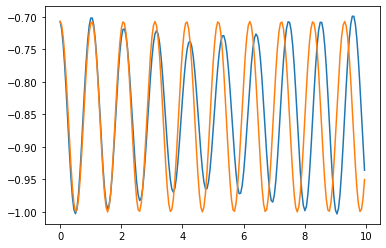

In [31]:
# cos th
time = 200
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 0].detach().numpy())
plt.plot(t_span.detach().numpy()[:time], obs[:time, 0])
plt.show()

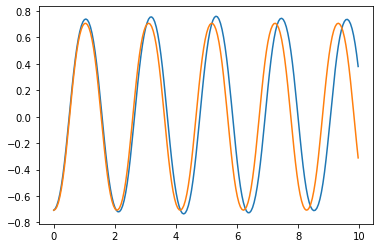

In [19]:
# sin th
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 1].detach().numpy())
plt.plot(t_span.detach().numpy()[:time], obs[:time, 1])

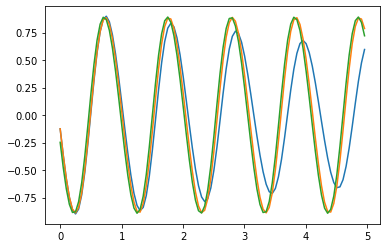

In [53]:
# d cos th
time = 100
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 2].detach().numpy())
plt.plot(t_span.detach().numpy()[:time], (obs[1:time+1, 0] - obs[0:time, 0])/0.05)

x1_truth = torch.sin(infos[:, 0]) * infos[:, 1]
plt.plot(t_span.detach().numpy()[:time], x1_truth.detach().numpy()[:time])

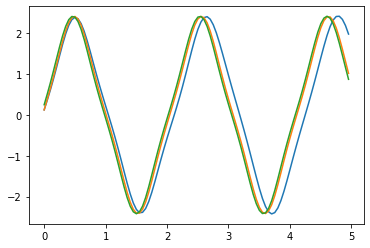

In [54]:
# d sin th
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 3].detach().numpy())
plt.plot(t_span.detach().numpy()[:time], (obs[1:time+1, 1] - obs[0:time, 1])/0.05)

x2_truth = torch.cos(infos[:, 0]) * infos[:, 1]
plt.plot(t_span.detach().numpy()[:time], x2_truth.detach().numpy()[:time])

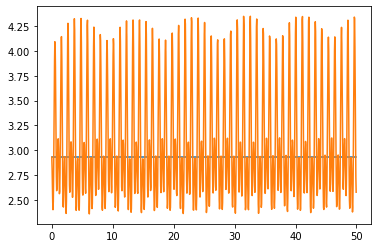

In [26]:
time = 999
# # Match theta
# plt.plot(t_span.detach().numpy()[:time], infos[:time, 0].detach().numpy())
# # test = torch.atan(-obs[:-1, 1] / obs[:-1, 0])
# test = torch.atan(-est[:-1, 0, 1] / est[:-1, 0, 0])
# plt.plot(t_span.detach().numpy()[:time], test[:time].detach().numpy())

# # Match theta_dot
# plt.plot(t_span.detach().numpy()[:time], (infos[:time, 1] ** 2 / 2).detach().numpy())
# # test = (vx ** 2 + vy ** 2) /2
# test = (est[:, 0, 2] ** 2 + est[:, 0, 3] ** 2) / 2
# plt.plot(t_span.detach().numpy()[:time], test[:time].detach().numpy())

# Match Energy
E1 = (infos[:, 1] ** 2) / 2 + 10 * (1-torch.cos(infos[:, 0]))

est_th = torch.atan(-est[:, 0, 1] / est[:, 0, 0])
est_thdot = (est[:, 0, 2] ** 2 + est[:, 0, 3] ** 2) / 2
E3 = (est_thdot ** 2) / 2 + 10 * (1-torch.cos(est_th))

plt.plot(t_span.detach().numpy()[:time], E1[:time].detach().numpy())
plt.plot(t_span.detach().numpy()[:time], E3[:time].detach().numpy())

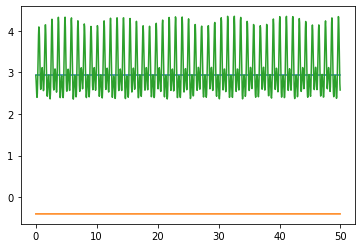

In [27]:
# Match Energy in Network form
E1 = (infos[:, 1] ** 2) / 2 + 10 * (1-torch.cos(infos[:, 0]))
E2 = learn.model.defunc.m.H(est[:,0,:])

plt.plot(t_span.detach().numpy()[:time], E1[:time].detach().numpy())
plt.plot(t_span.detach().numpy()[:time], E2[:time].detach().numpy())
plt.plot(t_span.detach().numpy()[:time], E3[:time].detach().numpy())

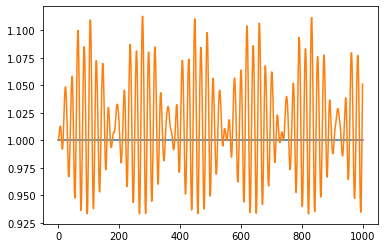

In [28]:
time = 1000
test1 = obs[:, 0] **2 + obs[:, 1] **2
test2 = est[:, 0, 0] ** 2 + est[:, 0, 1] ** 2
plt.plot(test1[:time])
plt.plot(test2.detach().numpy()[:time])

In [15]:
# Investigate Mass Matrix


In [ ]:
# Investigate Potential


In [ ]:
# Investigate individual dimension L


In [ ]:
# Ingestigate the derv

